<a href="https://colab.research.google.com/github/johnryantaylor/QCES/blob/main/Project1_dedalus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Solving the diffusion equation with Dedalus

**Overview:** This notebook solves the diffusion equation using a spectral method and provides an introduction to Dedalus.

**About Dedalus:** [Dedalus](http://dedalus-project.org) is an open-source Python package for solving partial differential equations (PDEs) using spectral methods.
These methods provide highly accurate numerical solutions for PDEs with smooth solutions in simple domains like boxes and spheres.
Dedalus implements modern parallel algorithms utilizing sparse polynomial bases, but all with an easy-to-use symbolic interface.
The code is being used in a wide range of fields, often for problems involving fluid dynamics.

This script is based in part on the Introduction to Dedalus by [Keaton Burns](http://keaton-burns.com)

The student exercise starts in [Section 5](#student_investigation)

# 1. Setup

First, we need to install Dedalus.  If you are running Python on your local computer, follow the install instructions in the [Dedalus Docs](https://dedalus-project.readthedocs.io/en/latest/pages/installation.html) to install Dedalus locally on your computer.

The cell below checks to see if Dedalus is installed.  After installing Dedalus, run the cell below to verify that Dedalus is installed correctly.

If you are using Google Colab, the cell below will automatically install Dedalus.

This cell checks if Dedalus is installed and performs some other basic setup. This will take some time the first time you run it.

Once you have Dedalus installed, you won't need to run this cell again.

In [3]:
# Set environment variables for best performance
%env OMP_NUM_THREADS=1
%env NUMEXPR_MAX_THREADS=1

# Minimize logging output
import logging
logging.disable(logging.DEBUG)

# Check if running on google colab
import os
using_google_colab = bool(os.getenv("COLAB_RELEASE_TAG"))

# Check for Dedalus
try:
    import dedalus.public as de
    print("Dedalus already installed :)")
except:
    print("Dedalus not installed yet.")
    if using_google_colab:
        print("Installing for Google Colab.")
        print()
        # Step 1: Install FFTW
        !apt-get install libfftw3-dev
        !apt-get install libfftw3-mpi-dev
        # Step 2: Set paths for Dedalus installation
        import os
        os.environ['MPI_INCLUDE_PATH'] = "/usr/lib/x86_64-linux-gnu/openmpi/include"
        os.environ['MPI_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        os.environ['FFTW_INCLUDE_PATH'] = "/usr/include"
        os.environ['FFTW_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        # Step 3: Install Dedalus using pip
        !pip3 install cython "mpi4py<4.0" numpy setuptools wheel
        !CC=mpicc pip3 install --no-cache --no-build-isolation http://github.com/dedalusproject/dedalus/zipball/master/
        !pip3 install -q ipympl
        # Step 4: Check installation
        print()
        try:
            import dedalus.public as de
            print("Dedalus successfully installed :)")
        except:
            print("Error installing Dedalus :(")
            raise
    else:
        print("See website for installation instructions:")
        print("https://dedalus-project.readthedocs.io/en/latest/pages/installation.html")

# Setup interactive matplotlib
if using_google_colab:
    from google.colab import output
    output.enable_custom_widget_manager()

env: OMP_NUM_THREADS=1
env: NUMEXPR_MAX_THREADS=1
Dedalus already installed :)


At the start of each Python script, we need to import the packages that we will use.  The cell below imports the packages that will be needed here, namely numpy, matplotlib (for plotting) and dedalus. Note that we assign aliases for numpy, matplotlib, and dedlaus. Run this cell before running any of the cells below.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

## 2. Dedalus basics

Dedalus solves PDEs using spectral methods.  Dedalus requires us to specify the spatial coordinates, the `distributor`, and the spectral bases, which are explained below.

### Coordinates

We can use a variety of coordinate systems in Dedalus. For example, for multi-dimensional problems, we can use Cartesian coordinates, polar coordinates, spherical coordinates, etc. Here, we will set up a 1D problem using the Dedalus `Coordinate` class. We will see other examples in future projects.
For more details on other problem types, included distributed parallel simulations, see the official [Dedalus Tutorial 1](https://dedalus-project.readthedocs.io/en/latest/notebooks/dedalus_tutorial_1.html).

Let's create a coordinate object representing our 1D coordinate, which here we will call `x`:

In [ ]:
xcoord = dedalus.Coordinate('x')

### Distributors

Dedalus uses MPI (Message Passing Interface) for allow parallel computation on distributed memory systems. There are various options for how to distribute the computation amongst the processes. In Dedalus this is done by an object called a `Distributor`. Here, we will run not run in paralle, but Dedalus still requies us to create a `Distributor` object. You don't need to worry about this now, we will discuss it further in later projects.

The line below creates a distributor for our x coordinate for a problem with real variables.

In [ ]:
dist = dedalus.Distributor(xcoord, dtype=np.float64) # No mesh for serial / automatic parallelization

### Spectral basis

Dedalus decomposes the PDE that we are solving using a spectral basis. Dedalus has the ability to use different basis functions for this decomposition, and this gives Dedalus remarkable flexibility. For example, `RealFourier` provides a Fouier basis (sine and cosine functions) can be used for problems that are periodic (cyclic) in physical space. The `Chebyshev` basis allows boundary conditions to be set on a finite interval. The `SphereBasis` allows us to solve problems on a sphere.

The line below creates a Fourier basis for a real-valued system with a domain size of Lx=10 and with Nx=1024 gridpoints in physical space.

In [ ]:
# Set some parameters
Nx = 1024 # The number of gridpoints. Note that Fourier transforms are more efficient if this is a power of 2
x_start=-1; x_end=1 # The starting and ending bounds on x

# Construct a Fourier basis
x_basis = dedalus.RealFourier(xcoord, size=Nx, bounds=(x_start, x_end))

### Grids

Each basis has a corresponding grid in physical space that can be used for tasks like initializing and plotting fields.

The line below creates a grid for the x coordinate.


In [ ]:
x = dist.local_grid(x_basis)

### Fields

`Field` objects in Dedalus represent scalar-valued fields defined over a set of bases (or a "domain").
For multidimensional problems, vector and tensor valued fields can also be constructed using the `VectorField` and `TensorField` clases.

Let's construct a field called `c` (for concentration) using our 1D basis:

In [ ]:
c = dist.Field(name='c', bases=x_basis)

Field objects have internal methods for transforming their data between grid (`'g'`) and coefficeint (`'c'`) space representations.
The field's values can be assigned and retrieved by indexing a field with these strings.

Let's set the grid-space values of our field, `c`, to be a Gaussian function of `x`. This is how we set the initial condition for the initial value problem that we will solve below.

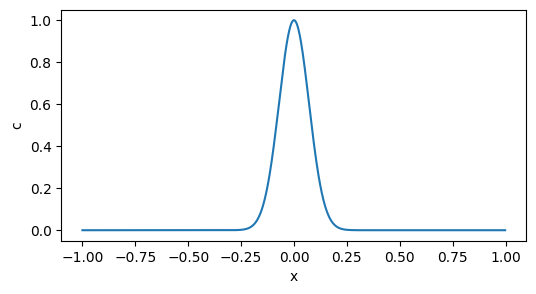

In [ ]:
w = 0.1 # Set the width of the initial Gaussian
c.change_scales(1) # Set values on regular grid
c['g'] = np.exp(-x**2/w**2)  # Initialize the dependent variable c with a Gaussian function (note ** is the exponentiation operator)

plt.figure(figsize=(6, 3)) # Set the size of the figure
plt.plot(x, c['g']) # Plot the "grid-space" initial conditions
plt.xlabel('x'); plt.ylabel("c"); # Set the axis labels

As a bit of an aside, we can find the coefficients of the spectral representation of a field using ['c'] instead of ['g'].
This triggers an in-place spectral (in this case Fourier) transform of the field's data.
For the `RealFourier` basis, the coefficients are the interleaved real-valued coefficients of the cosine and (negative) sine coefficients.
For very large problems transforming between grid and coefficient space will be time-consuming, so you will want to limit the number of times that this is done.

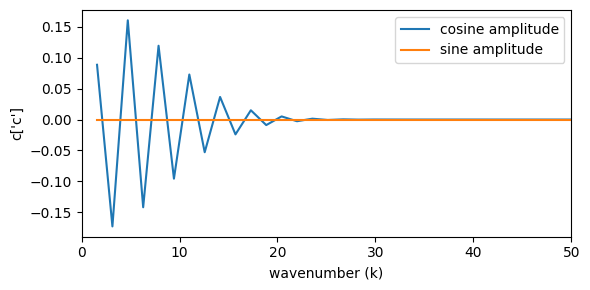

In [ ]:
k = np.pi * np.arange(1, Nx/2+1) / (x_end - x_start) # Create an array of wavenumbers, k(i)=i*pi/Lx
plt.figure(figsize=(6, 3))
plt.plot(k, c['c'][0::2], label='cosine amplitude')
plt.plot(k, -c['c'][1::2], label='sine amplitude')
plt.xlabel('wavenumber (k)')
plt.ylabel("c['c']")
plt.xlim(0, 50)
plt.legend()
plt.tight_layout()

## 3. Problems and Solvers

Dedalus uses Problem and Solver classes to specify the problem and the methods that will be used to solve it. Here, we will set up the diffusion equation and solve it using the Crank-Nicolson timestepping method.

For more details on other problem types, see [Dedalus Tutorial 3](https://dedalus-project.readthedocs.io/en/latest/notebooks/dedalus_tutorial_2.html).

### Problems

Dedalus standardizes the formulation of all initial value problems by taking systems of symbolically specified equations and boundary conditions specified in the following generic form:

$$\mathcal{M} \cdot \partial_t \mathcal{X} + \mathcal{L} \cdot \mathcal{X} = \mathcal{F}(\mathcal{X}, t)$$

where $\mathcal{M}$ and $\mathcal{L}$ are matrices of linear differential operators, $\mathcal{X}$ is a state vector of the unknown fields, $\mathcal{F}$ is a vector of general nonlinear expressions.

The left-hand side (LHS) of the equations must be first-order in temporal derivatives and linear in the problem variables.
The right-hand side (RHS) of the equations may contain nonlinear and time-dependent terms, but no temporal derivatives.

When using a mixed implicit/explicit timestepping scheme, Dedalus will apply the implicit method to the $\mathcal{L}\cdot \mathcal{X}$ term and the explicit method to the $\mathcal{F}(\mathcal{X}, t)$ term.

To create a problem object, we provide a list of the variables to be solved for. In this case, this is just `c`.

Equations can then be entered as pairs of operator expressions like `(LHS, RHS)` or as strings like `"LHS = RHS"`.

Here, let's set up the diffusion equation:

$$\partial_t c - \kappa \partial_x^2 c = 0$$

Note that we put the term with the second derivative on the left hand side of the equation so that it will be time-stepped implicitly.

In [ ]:
# Parameters
kappa = 0.001

# Operators
dx = lambda a: dedalus.Differentiate(a, xcoord) # Define the derivative (d/dx) operator

# Specify the problem
problem = dedalus.IVP([c], namespace=locals()) # Initial value problem, including all local variables
problem.add_equation("dt(c) - kappa*dx(dx(c)) = 0"); # Write out the equation to be solved


### 3.2 Solvers

Now, we need to specify the solver.  For IVPs, we specify a timestepping method when building the solver. Below we select the `CNAB1` timestepper which uses Crank-Nicolson for the $\mathcal{L}\cdot \mathcal{X}$ term and the explicit first order Adams-Bashforth method for the right hand side term (but in this case the RHS is zero).

In [ ]:
timestepper = dedalus.CNAB1
solver = problem.build_solver(timestepper)

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.5e+01/s


2024-12-24 23:28:11,939 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.5e+01/s


Next, we need to specify a condition for the simulation to end. This can be a set number of iterations (set using `solver.stop_iteration`), a stopping time in simulation time units (set using `solver.stop_sim_time`, or a maximum wall clock time in seconds (set using `solver.stop_wall_time`).



In [ ]:
solver.stop_sim_time = 10 # Stop at 10 simulation time units

IVPs are iterated using the `solver.step` method with a provided timestep.
The logic controlling the main-loop of a Dedalus IVP simulation occurs explicitly in the simulation script.
The `solver.proceed` property will change from `True` to `False` once any of the specified stopping criteria have been met.
Let's timestep our problem until the halting condition is reached, copying the grid values of `u` every few iterations.
This should take just a few seconds to run.

In [ ]:
# Main loop
timestep = 0.1
c.change_scales(1)
c_save = [np.copy(c['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
while solver.proceed:
    solver.step(timestep)
    if solver.iteration % 500 == 0: # Every 500 timesteps, print a message to the screen with the progress
        logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
    # save the values of c and t
    c.change_scales(1)
    c_save.append(np.copy(c['g']))
    t_save.append(solver.sim_time)

INFO:solvers:Simulation stop time reached.


2024-12-24 23:28:14,672 solvers 0/1 INFO :: Simulation stop time reached.


Now we can make a space-time plot of the solution:

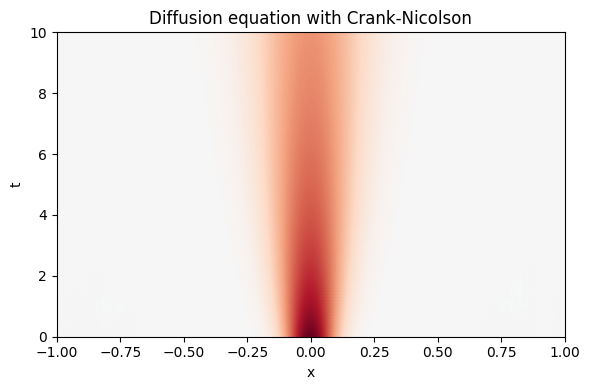

In [ ]:
# Plot
plt.figure(figsize=(6, 4))
plt.pcolormesh(x.ravel(), np.array(t_save), np.array(c_save), cmap='RdBu_r', shading='gouraud', rasterized=True, clim=(-1, 1))
plt.xlim(x_start, x_end)
plt.ylim(0, solver.stop_sim_time)
plt.xlabel('x')
plt.ylabel('t')
plt.title(f'Diffusion equation with Crank-Nicolson')
plt.tight_layout()

## 4. Forced diffusion equation

Dedalus is extremely flexible, which will make it very useful throughout the QCES computational projects. For example, it is relatively straightforward to change the equation that we are solving.

In order to introduce functions into the equations that Dedalus solves, we need to define a new operator.  For example, the following code defines the function $sin(x)$ on our grid:

In [ ]:
# Create an operator that applies a function to the variable on a grid
sin_x = dist.Field(bases=x_basis)
sin_x['g'] = np.sin(x)

The code below uses Dedlaus to solve the forced diffusion equation:

$$\partial_t c - \kappa \partial_x^2 c = cos(\pi x / Lx)$$

with the same Gaussian initial condition as before. This example also shows what a complete Dedalus script looks like.

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.8e+01/s


2024-12-24 23:28:23,522 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.8e+01/s


INFO:solvers:Simulation stop time reached.


2024-12-24 23:28:23,561 solvers 0/1 INFO :: Simulation stop time reached.


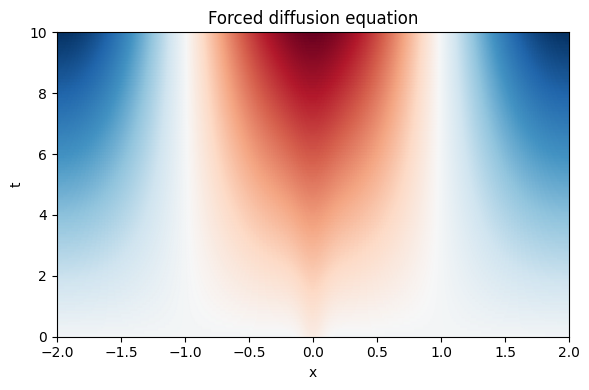

In [ ]:
# Load the required packages (these were loaded above and are inluded here for completeness)
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# This script solves the forced diffusion equation with Dedlaus

# Set some parameters for the problem to be solved
Nx = 1024 # The number of gridpoints. Note that Fourier transforms are more efficient if this is a power of 2
Lx = 2; # The domain size in x.  This should be large enough so that the solution goes to zero at the endpoints.
x_start=-Lx; x_end=Lx # The starting and ending bounds on x
kappa = 0.001 # set the diffusivity

# Create an x-coordinate, a corresponding basis, and a distributor
xcoord = dedalus.Coordinate('x')
dist = dedalus.Distributor(xcoord, dtype=np.float64) # No mesh for serial / automatic parallelization
x_basis = dedalus.RealFourier(xcoord, size=Nx, bounds=(x_start, x_end))
x = dist.local_grid(x_basis)

# Set initial conditions
c = dist.Field(name='c', bases=x_basis)
w = 0.1 # Set the width of the initial Gaussian
c.change_scales(1) # Set values on regular grid
c['g'] = np.exp(-x**2/w**2)  # Initialize the dependent variable c with a Gaussian function (note ** is the exponentiation operator)

# Operators
dx = lambda a: dedalus.Differentiate(a, xcoord) # Define the derivative (d/dx) operator

# Create an operator that applies a function to the variable on a grid
f_x = dist.Field(bases=x_basis)
f_x['g'] = np.cos(np.pi * x / Lx)

# Specify the problem
problem = dedalus.IVP([c], namespace=locals()) # Initial value problem, including all local variables
problem.add_equation("dt(c) - kappa * dx(dx(c)) = f_x"); # Write out the equation to be solved

timestepper = dedalus.CNAB1
solver = problem.build_solver(timestepper)

solver.stop_sim_time = 10 # Stop at 10 simulation time units

# Main loop
timestep = 0.1
c.change_scales(1)
c_save = [np.copy(c['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
while solver.proceed:
    solver.step(timestep)
    if solver.iteration % 500 == 0: # Every 500 timesteps, print a message to the screen with the progress
        logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
    c.change_scales(1)
    c_save.append(np.copy(c['g']))
    t_save.append(solver.sim_time)

# Plot
plt.figure(figsize=(6, 4))
plt.pcolormesh(x.ravel(), np.array(t_save), np.array(c_save), cmap='RdBu_r', shading='gouraud', rasterized=True)#, clim=(-1, 1))
plt.xlim(x_start, x_end)
plt.ylim(0, solver.stop_sim_time)
plt.xlabel('x')
plt.ylabel('t')
plt.title('Forced diffusion equation')
plt.tight_layout()

## 5. Student investigation
<a id='student_investigation'></a>

### 5.1 Steady-state solution to the forced diffusion equation

For the forced diffusion equation described in section 4, using dimensional analysis, estimate the time needed to reach a steady-state solution. Test this scaling, and discuss your results below. Run the code above for a sufficient time to achieve a steady-state solution. Plot $c$ at the end of this simulation, and compare it with the exact steady-state solution to the forced diffusion equation.

When estimating steady state, the time derivative term $\partial_t c$ is set to 0.
Therefore, the spatial derivative $-\kappa \partial_x^2 c$ should balance with the forcing term $\cos\left(\frac{\pi x}{L_x}\right)$.

The spatial derivative has a dimension of:

$$
[\partial_x^2 c] = \frac{[C]}{[L]^2}
$$

Thus, the dimension of the diffusion term $-\kappa \partial_x^2 c$ is:

$$
[\kappa \partial_x^2 c] = \frac{[C]}{[T]}
$$

because the diffusion coefficient $\kappa$ has the dimension $\frac{[L]^2}{[T]}$, and the second spatial derivative introduces a factor of $\frac{1}{[L]^2}$.

for the forcing term, $\cos\left(\frac{\pi x}{L_x}\right)$ is dimensionless, so we need a scaling factor to give it the same dimension as the diffusion term. Let this factor be $F$, with the dimension of:

$$
[F] = \frac{[C]}{[T]}
$$

Therefore, the forcing term has the dimension:

$$
[\text{Forcing Term}] = \frac{[C]}{[T]}
$$

$$
-\kappa \partial_x^2 c = F \cos\left(\frac{\pi x}{L_x}\right)
$$

For the balance to occur, the magnitude of $c$ needs to grow until the diffusion term $\kappa \partial_x^2 c$ becomes comparable to the forcing term. The time to reach steady state is the time it takes for the concentration to build up to a level where the magnitude of the diffusion term becomes comparable to the forcing.

$$
\kappa \frac{c}{L_x^2} \sim \frac{c}{\tau}
$$


$$
\tau \sim \frac{L_x^2}{\kappa}
$$

Therefore, the time to reach steady state is approximately:

$$
t_{\text{steady}} \sim \frac{L_x^2}{\kappa}
$$
given Lx = 2 and $\kappa = 0.001$, $t_steady = 4000s$

To solve exact solution, t derivative term is set to 0, and by intergration, we found$$
c(x) = \frac{L_x^2}{\kappa \pi^2} \cos\left(\frac{\pi x}{L_x}\right)
$$
the constant of integration is removed as in it is a periodic oscillation bounded by Lx.



the plot of c at $\tau$ evident that it is a good simulation as in simulation and exact solution overlaps, and the plot of difference between simulation and exact solution overtime shows that the estimation of $\tau$ is also reasonable.

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.0e+01/s


2024-12-24 23:48:37,693 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.0e+01/s


INFO:__main__:Iteration=500, Time=5.000000e+01, dt=1.000000e-01


2024-12-24 23:48:37,924 __main__ 0/1 INFO :: Iteration=500, Time=5.000000e+01, dt=1.000000e-01


INFO:__main__:Iteration=1000, Time=1.000000e+02, dt=1.000000e-01


2024-12-24 23:48:38,152 __main__ 0/1 INFO :: Iteration=1000, Time=1.000000e+02, dt=1.000000e-01


INFO:__main__:Iteration=1500, Time=1.500000e+02, dt=1.000000e-01


2024-12-24 23:48:38,399 __main__ 0/1 INFO :: Iteration=1500, Time=1.500000e+02, dt=1.000000e-01


INFO:__main__:Iteration=2000, Time=2.000000e+02, dt=1.000000e-01


2024-12-24 23:48:38,617 __main__ 0/1 INFO :: Iteration=2000, Time=2.000000e+02, dt=1.000000e-01


INFO:__main__:Iteration=2500, Time=2.500000e+02, dt=1.000000e-01


2024-12-24 23:48:38,815 __main__ 0/1 INFO :: Iteration=2500, Time=2.500000e+02, dt=1.000000e-01


INFO:__main__:Iteration=3000, Time=3.000000e+02, dt=1.000000e-01


2024-12-24 23:48:39,016 __main__ 0/1 INFO :: Iteration=3000, Time=3.000000e+02, dt=1.000000e-01


INFO:__main__:Iteration=3500, Time=3.500000e+02, dt=1.000000e-01


2024-12-24 23:48:39,214 __main__ 0/1 INFO :: Iteration=3500, Time=3.500000e+02, dt=1.000000e-01


INFO:__main__:Iteration=4000, Time=4.000000e+02, dt=1.000000e-01


2024-12-24 23:48:39,470 __main__ 0/1 INFO :: Iteration=4000, Time=4.000000e+02, dt=1.000000e-01


INFO:__main__:Iteration=4500, Time=4.500000e+02, dt=1.000000e-01


2024-12-24 23:48:39,670 __main__ 0/1 INFO :: Iteration=4500, Time=4.500000e+02, dt=1.000000e-01


INFO:__main__:Iteration=5000, Time=5.000000e+02, dt=1.000000e-01


2024-12-24 23:48:39,871 __main__ 0/1 INFO :: Iteration=5000, Time=5.000000e+02, dt=1.000000e-01


INFO:__main__:Iteration=5500, Time=5.500000e+02, dt=1.000000e-01


2024-12-24 23:48:40,062 __main__ 0/1 INFO :: Iteration=5500, Time=5.500000e+02, dt=1.000000e-01


INFO:__main__:Iteration=6000, Time=6.000000e+02, dt=1.000000e-01


2024-12-24 23:48:40,265 __main__ 0/1 INFO :: Iteration=6000, Time=6.000000e+02, dt=1.000000e-01


INFO:__main__:Iteration=6500, Time=6.500000e+02, dt=1.000000e-01


2024-12-24 23:48:40,491 __main__ 0/1 INFO :: Iteration=6500, Time=6.500000e+02, dt=1.000000e-01


INFO:__main__:Iteration=7000, Time=7.000000e+02, dt=1.000000e-01


2024-12-24 23:48:40,682 __main__ 0/1 INFO :: Iteration=7000, Time=7.000000e+02, dt=1.000000e-01


INFO:__main__:Iteration=7500, Time=7.500000e+02, dt=1.000000e-01


2024-12-24 23:48:40,880 __main__ 0/1 INFO :: Iteration=7500, Time=7.500000e+02, dt=1.000000e-01


INFO:__main__:Iteration=8000, Time=8.000000e+02, dt=1.000000e-01


2024-12-24 23:48:41,090 __main__ 0/1 INFO :: Iteration=8000, Time=8.000000e+02, dt=1.000000e-01


INFO:__main__:Iteration=8500, Time=8.500000e+02, dt=1.000000e-01


2024-12-24 23:48:41,296 __main__ 0/1 INFO :: Iteration=8500, Time=8.500000e+02, dt=1.000000e-01


INFO:__main__:Iteration=9000, Time=9.000000e+02, dt=1.000000e-01


2024-12-24 23:48:41,524 __main__ 0/1 INFO :: Iteration=9000, Time=9.000000e+02, dt=1.000000e-01


INFO:__main__:Iteration=9500, Time=9.500000e+02, dt=1.000000e-01


2024-12-24 23:48:41,713 __main__ 0/1 INFO :: Iteration=9500, Time=9.500000e+02, dt=1.000000e-01


INFO:__main__:Iteration=10000, Time=1.000000e+03, dt=1.000000e-01


2024-12-24 23:48:41,916 __main__ 0/1 INFO :: Iteration=10000, Time=1.000000e+03, dt=1.000000e-01


INFO:__main__:Iteration=10500, Time=1.050000e+03, dt=1.000000e-01


2024-12-24 23:48:42,142 __main__ 0/1 INFO :: Iteration=10500, Time=1.050000e+03, dt=1.000000e-01


INFO:__main__:Iteration=11000, Time=1.100000e+03, dt=1.000000e-01


2024-12-24 23:48:42,354 __main__ 0/1 INFO :: Iteration=11000, Time=1.100000e+03, dt=1.000000e-01


INFO:__main__:Iteration=11500, Time=1.150000e+03, dt=1.000000e-01


2024-12-24 23:48:42,598 __main__ 0/1 INFO :: Iteration=11500, Time=1.150000e+03, dt=1.000000e-01


INFO:__main__:Iteration=12000, Time=1.200000e+03, dt=1.000000e-01


2024-12-24 23:48:42,802 __main__ 0/1 INFO :: Iteration=12000, Time=1.200000e+03, dt=1.000000e-01


INFO:__main__:Iteration=12500, Time=1.250000e+03, dt=1.000000e-01


2024-12-24 23:48:43,004 __main__ 0/1 INFO :: Iteration=12500, Time=1.250000e+03, dt=1.000000e-01


INFO:__main__:Iteration=13000, Time=1.300000e+03, dt=1.000000e-01


2024-12-24 23:48:43,199 __main__ 0/1 INFO :: Iteration=13000, Time=1.300000e+03, dt=1.000000e-01


INFO:__main__:Iteration=13500, Time=1.350000e+03, dt=1.000000e-01


2024-12-24 23:48:43,398 __main__ 0/1 INFO :: Iteration=13500, Time=1.350000e+03, dt=1.000000e-01


INFO:__main__:Iteration=14000, Time=1.400000e+03, dt=1.000000e-01


2024-12-24 23:48:43,633 __main__ 0/1 INFO :: Iteration=14000, Time=1.400000e+03, dt=1.000000e-01


INFO:__main__:Iteration=14500, Time=1.450000e+03, dt=1.000000e-01


2024-12-24 23:48:43,831 __main__ 0/1 INFO :: Iteration=14500, Time=1.450000e+03, dt=1.000000e-01


INFO:__main__:Iteration=15000, Time=1.500000e+03, dt=1.000000e-01


2024-12-24 23:48:44,023 __main__ 0/1 INFO :: Iteration=15000, Time=1.500000e+03, dt=1.000000e-01


INFO:__main__:Iteration=15500, Time=1.550000e+03, dt=1.000000e-01


2024-12-24 23:48:44,230 __main__ 0/1 INFO :: Iteration=15500, Time=1.550000e+03, dt=1.000000e-01


INFO:__main__:Iteration=16000, Time=1.600000e+03, dt=1.000000e-01


2024-12-24 23:48:44,438 __main__ 0/1 INFO :: Iteration=16000, Time=1.600000e+03, dt=1.000000e-01


INFO:__main__:Iteration=16500, Time=1.650000e+03, dt=1.000000e-01


2024-12-24 23:48:44,642 __main__ 0/1 INFO :: Iteration=16500, Time=1.650000e+03, dt=1.000000e-01


INFO:__main__:Iteration=17000, Time=1.700000e+03, dt=1.000000e-01


2024-12-24 23:48:44,843 __main__ 0/1 INFO :: Iteration=17000, Time=1.700000e+03, dt=1.000000e-01


INFO:__main__:Iteration=17500, Time=1.750000e+03, dt=1.000000e-01


2024-12-24 23:48:45,054 __main__ 0/1 INFO :: Iteration=17500, Time=1.750000e+03, dt=1.000000e-01


INFO:__main__:Iteration=18000, Time=1.800000e+03, dt=1.000000e-01


2024-12-24 23:48:45,256 __main__ 0/1 INFO :: Iteration=18000, Time=1.800000e+03, dt=1.000000e-01


INFO:__main__:Iteration=18500, Time=1.850000e+03, dt=1.000000e-01


2024-12-24 23:48:45,461 __main__ 0/1 INFO :: Iteration=18500, Time=1.850000e+03, dt=1.000000e-01


INFO:__main__:Iteration=19000, Time=1.900000e+03, dt=1.000000e-01


2024-12-24 23:48:45,670 __main__ 0/1 INFO :: Iteration=19000, Time=1.900000e+03, dt=1.000000e-01


INFO:__main__:Iteration=19500, Time=1.950000e+03, dt=1.000000e-01


2024-12-24 23:48:45,869 __main__ 0/1 INFO :: Iteration=19500, Time=1.950000e+03, dt=1.000000e-01


INFO:__main__:Iteration=20000, Time=2.000000e+03, dt=1.000000e-01


2024-12-24 23:48:46,078 __main__ 0/1 INFO :: Iteration=20000, Time=2.000000e+03, dt=1.000000e-01


INFO:__main__:Iteration=20500, Time=2.050000e+03, dt=1.000000e-01


2024-12-24 23:48:46,270 __main__ 0/1 INFO :: Iteration=20500, Time=2.050000e+03, dt=1.000000e-01


INFO:__main__:Iteration=21000, Time=2.100000e+03, dt=1.000000e-01


2024-12-24 23:48:46,598 __main__ 0/1 INFO :: Iteration=21000, Time=2.100000e+03, dt=1.000000e-01


INFO:__main__:Iteration=21500, Time=2.150000e+03, dt=1.000000e-01


2024-12-24 23:48:46,911 __main__ 0/1 INFO :: Iteration=21500, Time=2.150000e+03, dt=1.000000e-01


INFO:__main__:Iteration=22000, Time=2.200000e+03, dt=1.000000e-01


2024-12-24 23:48:47,308 __main__ 0/1 INFO :: Iteration=22000, Time=2.200000e+03, dt=1.000000e-01


INFO:__main__:Iteration=22500, Time=2.250000e+03, dt=1.000000e-01


2024-12-24 23:48:47,665 __main__ 0/1 INFO :: Iteration=22500, Time=2.250000e+03, dt=1.000000e-01


INFO:__main__:Iteration=23000, Time=2.300000e+03, dt=1.000000e-01


2024-12-24 23:48:47,952 __main__ 0/1 INFO :: Iteration=23000, Time=2.300000e+03, dt=1.000000e-01


INFO:__main__:Iteration=23500, Time=2.350000e+03, dt=1.000000e-01


2024-12-24 23:48:48,244 __main__ 0/1 INFO :: Iteration=23500, Time=2.350000e+03, dt=1.000000e-01


INFO:__main__:Iteration=24000, Time=2.400000e+03, dt=1.000000e-01


2024-12-24 23:48:48,597 __main__ 0/1 INFO :: Iteration=24000, Time=2.400000e+03, dt=1.000000e-01


INFO:__main__:Iteration=24500, Time=2.450000e+03, dt=1.000000e-01


2024-12-24 23:48:48,946 __main__ 0/1 INFO :: Iteration=24500, Time=2.450000e+03, dt=1.000000e-01


INFO:__main__:Iteration=25000, Time=2.500000e+03, dt=1.000000e-01


2024-12-24 23:48:49,276 __main__ 0/1 INFO :: Iteration=25000, Time=2.500000e+03, dt=1.000000e-01


INFO:__main__:Iteration=25500, Time=2.550000e+03, dt=1.000000e-01


2024-12-24 23:48:49,615 __main__ 0/1 INFO :: Iteration=25500, Time=2.550000e+03, dt=1.000000e-01


INFO:__main__:Iteration=26000, Time=2.600000e+03, dt=1.000000e-01


2024-12-24 23:48:49,949 __main__ 0/1 INFO :: Iteration=26000, Time=2.600000e+03, dt=1.000000e-01


INFO:__main__:Iteration=26500, Time=2.650000e+03, dt=1.000000e-01


2024-12-24 23:48:50,280 __main__ 0/1 INFO :: Iteration=26500, Time=2.650000e+03, dt=1.000000e-01


INFO:__main__:Iteration=27000, Time=2.700000e+03, dt=1.000000e-01


2024-12-24 23:48:50,569 __main__ 0/1 INFO :: Iteration=27000, Time=2.700000e+03, dt=1.000000e-01


INFO:__main__:Iteration=27500, Time=2.750000e+03, dt=1.000000e-01


2024-12-24 23:48:50,761 __main__ 0/1 INFO :: Iteration=27500, Time=2.750000e+03, dt=1.000000e-01


INFO:__main__:Iteration=28000, Time=2.800000e+03, dt=1.000000e-01


2024-12-24 23:48:50,992 __main__ 0/1 INFO :: Iteration=28000, Time=2.800000e+03, dt=1.000000e-01


INFO:__main__:Iteration=28500, Time=2.850000e+03, dt=1.000000e-01


2024-12-24 23:48:51,192 __main__ 0/1 INFO :: Iteration=28500, Time=2.850000e+03, dt=1.000000e-01


INFO:__main__:Iteration=29000, Time=2.900000e+03, dt=1.000000e-01


2024-12-24 23:48:51,387 __main__ 0/1 INFO :: Iteration=29000, Time=2.900000e+03, dt=1.000000e-01


INFO:__main__:Iteration=29500, Time=2.950000e+03, dt=1.000000e-01


2024-12-24 23:48:51,602 __main__ 0/1 INFO :: Iteration=29500, Time=2.950000e+03, dt=1.000000e-01


INFO:__main__:Iteration=30000, Time=3.000000e+03, dt=1.000000e-01


2024-12-24 23:48:51,800 __main__ 0/1 INFO :: Iteration=30000, Time=3.000000e+03, dt=1.000000e-01


INFO:__main__:Iteration=30500, Time=3.050000e+03, dt=1.000000e-01


2024-12-24 23:48:52,016 __main__ 0/1 INFO :: Iteration=30500, Time=3.050000e+03, dt=1.000000e-01


INFO:__main__:Iteration=31000, Time=3.100000e+03, dt=1.000000e-01


2024-12-24 23:48:52,230 __main__ 0/1 INFO :: Iteration=31000, Time=3.100000e+03, dt=1.000000e-01


INFO:__main__:Iteration=31500, Time=3.150000e+03, dt=1.000000e-01


2024-12-24 23:48:52,450 __main__ 0/1 INFO :: Iteration=31500, Time=3.150000e+03, dt=1.000000e-01


INFO:__main__:Iteration=32000, Time=3.200000e+03, dt=1.000000e-01


2024-12-24 23:48:52,644 __main__ 0/1 INFO :: Iteration=32000, Time=3.200000e+03, dt=1.000000e-01


INFO:__main__:Iteration=32500, Time=3.250000e+03, dt=1.000000e-01


2024-12-24 23:48:52,841 __main__ 0/1 INFO :: Iteration=32500, Time=3.250000e+03, dt=1.000000e-01


INFO:__main__:Iteration=33000, Time=3.300000e+03, dt=1.000000e-01


2024-12-24 23:48:53,058 __main__ 0/1 INFO :: Iteration=33000, Time=3.300000e+03, dt=1.000000e-01


INFO:__main__:Iteration=33500, Time=3.350000e+03, dt=1.000000e-01


2024-12-24 23:48:53,263 __main__ 0/1 INFO :: Iteration=33500, Time=3.350000e+03, dt=1.000000e-01


INFO:__main__:Iteration=34000, Time=3.400000e+03, dt=1.000000e-01


2024-12-24 23:48:53,476 __main__ 0/1 INFO :: Iteration=34000, Time=3.400000e+03, dt=1.000000e-01


INFO:__main__:Iteration=34500, Time=3.450000e+03, dt=1.000000e-01


2024-12-24 23:48:53,672 __main__ 0/1 INFO :: Iteration=34500, Time=3.450000e+03, dt=1.000000e-01


INFO:__main__:Iteration=35000, Time=3.500000e+03, dt=1.000000e-01


2024-12-24 23:48:53,872 __main__ 0/1 INFO :: Iteration=35000, Time=3.500000e+03, dt=1.000000e-01


INFO:__main__:Iteration=35500, Time=3.550000e+03, dt=1.000000e-01


2024-12-24 23:48:54,084 __main__ 0/1 INFO :: Iteration=35500, Time=3.550000e+03, dt=1.000000e-01


INFO:__main__:Iteration=36000, Time=3.600000e+03, dt=1.000000e-01


2024-12-24 23:48:54,283 __main__ 0/1 INFO :: Iteration=36000, Time=3.600000e+03, dt=1.000000e-01


INFO:__main__:Iteration=36500, Time=3.650000e+03, dt=1.000000e-01


2024-12-24 23:48:54,497 __main__ 0/1 INFO :: Iteration=36500, Time=3.650000e+03, dt=1.000000e-01


INFO:__main__:Iteration=37000, Time=3.700000e+03, dt=1.000000e-01


2024-12-24 23:48:54,691 __main__ 0/1 INFO :: Iteration=37000, Time=3.700000e+03, dt=1.000000e-01


INFO:__main__:Iteration=37500, Time=3.750000e+03, dt=1.000000e-01


2024-12-24 23:48:54,888 __main__ 0/1 INFO :: Iteration=37500, Time=3.750000e+03, dt=1.000000e-01


INFO:__main__:Iteration=38000, Time=3.800000e+03, dt=1.000000e-01


2024-12-24 23:48:55,109 __main__ 0/1 INFO :: Iteration=38000, Time=3.800000e+03, dt=1.000000e-01


INFO:__main__:Iteration=38500, Time=3.850000e+03, dt=1.000000e-01


2024-12-24 23:48:55,308 __main__ 0/1 INFO :: Iteration=38500, Time=3.850000e+03, dt=1.000000e-01


INFO:__main__:Iteration=39000, Time=3.900000e+03, dt=1.000000e-01


2024-12-24 23:48:55,525 __main__ 0/1 INFO :: Iteration=39000, Time=3.900000e+03, dt=1.000000e-01


INFO:__main__:Iteration=39500, Time=3.950000e+03, dt=1.000000e-01


2024-12-24 23:48:55,718 __main__ 0/1 INFO :: Iteration=39500, Time=3.950000e+03, dt=1.000000e-01


INFO:__main__:Iteration=40000, Time=4.000000e+03, dt=1.000000e-01


2024-12-24 23:48:55,918 __main__ 0/1 INFO :: Iteration=40000, Time=4.000000e+03, dt=1.000000e-01


INFO:solvers:Simulation stop time reached.


2024-12-24 23:48:55,924 solvers 0/1 INFO :: Simulation stop time reached.


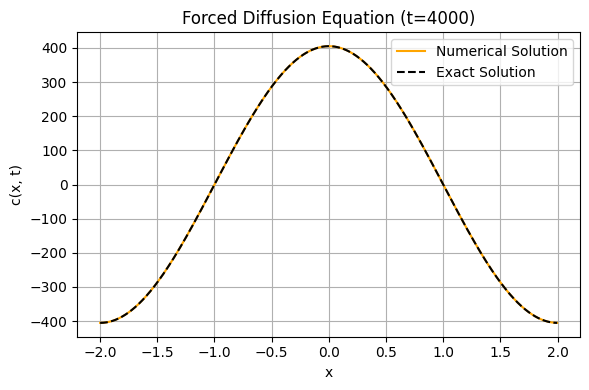

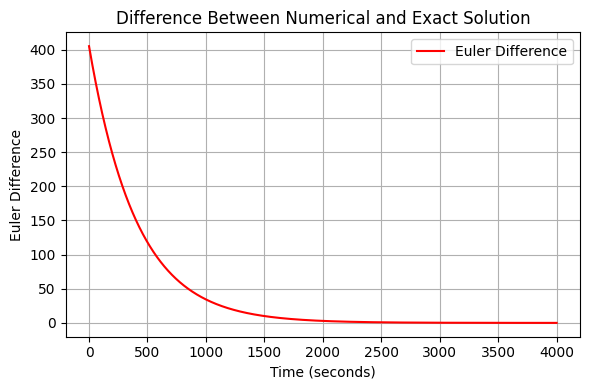

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as dedalus
import logging

# Set parameters
Lx = 2
Nx = 1024
x_start = -Lx
x_end = Lx
kappa = 0.001
t_end = 4000

# Create an x-coordinate, a corresponding basis, and a distributor
xcoord = dedalus.Coordinate('x')
dist = dedalus.Distributor(xcoord, dtype=np.float64)  # No mesh for serial / automatic parallelization
x_basis = dedalus.RealFourier(xcoord, size=Nx, bounds=(x_start, x_end))
x = dist.local_grid(x_basis)

# Set initial conditions
c = dist.Field(name='c', bases=x_basis)
w = 0.1  # Set the width of the initial Gaussian
c.change_scales(1)  # Set values on regular grid
c['g'] = np.exp(-x**2/w**2)  # Initialize the dependent variable c with a Gaussian function

# Operators
dx = lambda a: dedalus.Differentiate(a, xcoord)  # Define the derivative (d/dx) operator

# Create an operator that applies a function to the variable on a grid
f_x = dist.Field(bases=x_basis)
f_x['g'] = np.cos(np.pi * x / Lx)

# Specify the problem
problem = dedalus.IVP([c], namespace=locals())  # Initial value problem, including all local variables
problem.add_equation("dt(c) - kappa * dx(dx(c)) = f_x")  # Write out the equation to be solved

# Solver setup
timestepper = dedalus.CNAB1
solver = problem.build_solver(timestepper)
solver.stop_sim_time = t_end  # Stop at 4000 simulation time units

# Main loop parameters
timestep = 0.1
c.change_scales(1)
c_save = [np.copy(c['g'])]
t_save = [solver.sim_time]  # Save the initial condition and the initial time

# Exact solution for comparison
def exact_solution(x):
    return (Lx**2 / (kappa * np.pi**2)) * np.cos(np.pi * x / Lx)

# List to store errors
errors = []

# Main time-stepping loop
while solver.proceed:
    solver.step(timestep)
    if solver.iteration % 500 == 0:  # Every 500 timesteps, print a message to the screen with the progress
        logger.info('Iteration=%i, Time=%e, dt=%e' % (solver.iteration, solver.sim_time, timestep))

    c.change_scales(1)
    c_save.append(np.copy(c['g']))

    # Calculate the Euler difference error (difference between numerical and exact solutions)
    error = np.abs(c['g'] - exact_solution(x))  # Absolute difference
    errors.append(np.max(error))  # Store the maximum error at each timestep


    # Append the current time after calculating the error
    t_save.append(solver.sim_time)
t_save = t_save[:-1]

plt.figure(figsize=(6, 4))
plt.plot(x, c_save[-1], label="Numerical Solution", color='orange')
plt.plot(x, exact_solution(x), label="Exact Solution", color='black', linestyle='--')
plt.xlabel('x')
plt.ylabel('c(x, t)')
plt.title(f"Forced Diffusion Equation (t={t_end})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot the error between the numerical and exact solution over time
plt.figure(figsize=(6, 4))
plt.plot(t_save, errors, label="Euler Difference", color='red')
plt.xlabel('Time (seconds)')
plt.ylabel('Euler Difference')
plt.title("Difference Between Numerical and Exact Solution")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Students should comment on the timescale needed to transition from the initial condition to the forced solution, and comment on the diffusive and forcing timescales.

### 5.2 Variable difusivity

In some applications of the diffusion equation, the diffusivity varies in space. This happens, for example, in the movement of pollution in groundwater flowing through soil of variable porosity, or the mixing of tracers due to turbulence in the ocean (which we will explore in detail in Project 2).

In the code cell below, write a Dedalus script that solves the following equation:

$$\partial_t c - \partial_x(\kappa (x) \partial_x c) = 0$$

where

$$\kappa(x)=\kappa_0(0.1 + tanh(x/0.1)+1)/2$$

and $\kappa_0=0.001$. It is fine to start by copying the code in the previous cell and changing the problem equation appropriately.

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as dedalus
import logging

# Set up logging
logger = logging.getLogger(__name__)

# Problem parameters
Lx = 2
Nx = 1024
x_start = -Lx
x_end = Lx
k0 = 0.001
t_end = 10  # Set final time to 10 seconds

# Create a coordinate and distributor for Dedalus
xcoord = dedalus.Coordinate('x')
dist = dedalus.Distributor(xcoord, dtype=np.float64)
x_basis = dedalus.RealFourier(xcoord, size=Nx, bounds=(x_start, x_end))
x = dist.local_grid(x_basis)

# Set initial conditions
c = dist.Field(name='c', bases=x_basis)
w = 0.1  # Set the width of the initial Gaussian
c.change_scales(1)  # Set values on regular grid
c['g'] = np.exp(-x**2/w**2)  # Initialize the dependent variable c with a Gaussian function

# Define kappa as a spatially varying field
kappa = dist.Field(name='kappa', bases=x_basis)
kappa['g'] = k0 * (0.1 + np.tanh(x / 0.1) + 1) / 2  # Spatially varying kappa

# Define the differential operator
dx = lambda a: dedalus.Differentiate(a, xcoord)  # Define the derivative (d/dx) operator

# Forcing term (zero in this case)
f_x = dist.Field(bases=x_basis)
f_x['g'] = 0

# Specify the problem
problem = dedalus.IVP([c], namespace=locals())  # Initial value problem, including all local variables
problem.add_equation("dt(c) - dx(kappa * dx(c)) = f_x")  # Diffusion equation

# Set up the solver
timestepper = dedalus.CNAB1
solver = problem.build_solver(timestepper)

# Set stop time for the simulation to 10
solver.stop_sim_time = t_end  # Stop at 10 simulation time units

# Main loop setup
timestep = 0.1
c.change_scales(1)
c_save = [np.copy(c['g'])]
t_save = [solver.sim_time]  # Save the initial condition and the initial time

# Set the save interval to 2 iterations for more frequent data saving
save_interval = 2  # Save data every 2 iterations

while solver.proceed:
    solver.step(timestep)

    # Save the data every 2 timesteps
    if solver.iteration % save_interval == 0:
        logger.info('Iteration=%i, Time=%e, dt=%e' % (solver.iteration, solver.sim_time, timestep))

        c.change_scales(1)
        c_save.append(np.copy(c['g']))
        t_save.append(solver.sim_time)

        # Save the data to a file (only every save_interval iterations)
        np.savez('simulation_data.npz', x=x, t_save=t_save, c_save=c_save)

# After the simulation ends, save the final data
np.savez('final_simulation_data.npz', x=x, t_save=t_save, c_save=c_save)


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 5.3e-01/s


2024-12-25 00:21:58,538 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 5.3e-01/s


INFO:__main__:Iteration=2, Time=2.000000e-01, dt=1.000000e-01


2024-12-25 00:21:58,703 __main__ 0/1 INFO :: Iteration=2, Time=2.000000e-01, dt=1.000000e-01


INFO:__main__:Iteration=4, Time=4.000000e-01, dt=1.000000e-01


2024-12-25 00:21:58,716 __main__ 0/1 INFO :: Iteration=4, Time=4.000000e-01, dt=1.000000e-01


INFO:__main__:Iteration=6, Time=6.000000e-01, dt=1.000000e-01


2024-12-25 00:21:58,730 __main__ 0/1 INFO :: Iteration=6, Time=6.000000e-01, dt=1.000000e-01


INFO:__main__:Iteration=8, Time=8.000000e-01, dt=1.000000e-01


2024-12-25 00:21:58,743 __main__ 0/1 INFO :: Iteration=8, Time=8.000000e-01, dt=1.000000e-01


INFO:__main__:Iteration=10, Time=1.000000e+00, dt=1.000000e-01


2024-12-25 00:21:58,755 __main__ 0/1 INFO :: Iteration=10, Time=1.000000e+00, dt=1.000000e-01


INFO:__main__:Iteration=12, Time=1.200000e+00, dt=1.000000e-01


2024-12-25 00:21:58,768 __main__ 0/1 INFO :: Iteration=12, Time=1.200000e+00, dt=1.000000e-01


INFO:__main__:Iteration=14, Time=1.400000e+00, dt=1.000000e-01


2024-12-25 00:21:58,780 __main__ 0/1 INFO :: Iteration=14, Time=1.400000e+00, dt=1.000000e-01


INFO:__main__:Iteration=16, Time=1.600000e+00, dt=1.000000e-01


2024-12-25 00:21:58,793 __main__ 0/1 INFO :: Iteration=16, Time=1.600000e+00, dt=1.000000e-01


INFO:__main__:Iteration=18, Time=1.800000e+00, dt=1.000000e-01


2024-12-25 00:21:58,808 __main__ 0/1 INFO :: Iteration=18, Time=1.800000e+00, dt=1.000000e-01


INFO:__main__:Iteration=20, Time=2.000000e+00, dt=1.000000e-01


2024-12-25 00:21:58,821 __main__ 0/1 INFO :: Iteration=20, Time=2.000000e+00, dt=1.000000e-01


INFO:__main__:Iteration=22, Time=2.200000e+00, dt=1.000000e-01


2024-12-25 00:21:58,835 __main__ 0/1 INFO :: Iteration=22, Time=2.200000e+00, dt=1.000000e-01


INFO:__main__:Iteration=24, Time=2.400000e+00, dt=1.000000e-01


2024-12-25 00:21:58,849 __main__ 0/1 INFO :: Iteration=24, Time=2.400000e+00, dt=1.000000e-01


INFO:__main__:Iteration=26, Time=2.600000e+00, dt=1.000000e-01


2024-12-25 00:21:58,863 __main__ 0/1 INFO :: Iteration=26, Time=2.600000e+00, dt=1.000000e-01


INFO:__main__:Iteration=28, Time=2.800000e+00, dt=1.000000e-01


2024-12-25 00:21:58,881 __main__ 0/1 INFO :: Iteration=28, Time=2.800000e+00, dt=1.000000e-01


INFO:__main__:Iteration=30, Time=3.000000e+00, dt=1.000000e-01


2024-12-25 00:21:58,896 __main__ 0/1 INFO :: Iteration=30, Time=3.000000e+00, dt=1.000000e-01


INFO:__main__:Iteration=32, Time=3.200000e+00, dt=1.000000e-01


2024-12-25 00:21:58,911 __main__ 0/1 INFO :: Iteration=32, Time=3.200000e+00, dt=1.000000e-01


INFO:__main__:Iteration=34, Time=3.400000e+00, dt=1.000000e-01


2024-12-25 00:21:58,929 __main__ 0/1 INFO :: Iteration=34, Time=3.400000e+00, dt=1.000000e-01


INFO:__main__:Iteration=36, Time=3.600000e+00, dt=1.000000e-01


2024-12-25 00:21:58,944 __main__ 0/1 INFO :: Iteration=36, Time=3.600000e+00, dt=1.000000e-01


INFO:__main__:Iteration=38, Time=3.800000e+00, dt=1.000000e-01


2024-12-25 00:21:58,958 __main__ 0/1 INFO :: Iteration=38, Time=3.800000e+00, dt=1.000000e-01


INFO:__main__:Iteration=40, Time=4.000000e+00, dt=1.000000e-01


2024-12-25 00:21:58,973 __main__ 0/1 INFO :: Iteration=40, Time=4.000000e+00, dt=1.000000e-01


INFO:__main__:Iteration=42, Time=4.200000e+00, dt=1.000000e-01


2024-12-25 00:21:58,987 __main__ 0/1 INFO :: Iteration=42, Time=4.200000e+00, dt=1.000000e-01


INFO:__main__:Iteration=44, Time=4.400000e+00, dt=1.000000e-01


2024-12-25 00:21:59,001 __main__ 0/1 INFO :: Iteration=44, Time=4.400000e+00, dt=1.000000e-01


INFO:__main__:Iteration=46, Time=4.600000e+00, dt=1.000000e-01


2024-12-25 00:21:59,016 __main__ 0/1 INFO :: Iteration=46, Time=4.600000e+00, dt=1.000000e-01


INFO:__main__:Iteration=48, Time=4.800000e+00, dt=1.000000e-01


2024-12-25 00:21:59,029 __main__ 0/1 INFO :: Iteration=48, Time=4.800000e+00, dt=1.000000e-01


INFO:__main__:Iteration=50, Time=5.000000e+00, dt=1.000000e-01


2024-12-25 00:21:59,043 __main__ 0/1 INFO :: Iteration=50, Time=5.000000e+00, dt=1.000000e-01


INFO:__main__:Iteration=52, Time=5.200000e+00, dt=1.000000e-01


2024-12-25 00:21:59,063 __main__ 0/1 INFO :: Iteration=52, Time=5.200000e+00, dt=1.000000e-01


INFO:__main__:Iteration=54, Time=5.400000e+00, dt=1.000000e-01


2024-12-25 00:21:59,083 __main__ 0/1 INFO :: Iteration=54, Time=5.400000e+00, dt=1.000000e-01


INFO:__main__:Iteration=56, Time=5.600000e+00, dt=1.000000e-01


2024-12-25 00:21:59,098 __main__ 0/1 INFO :: Iteration=56, Time=5.600000e+00, dt=1.000000e-01


INFO:__main__:Iteration=58, Time=5.800000e+00, dt=1.000000e-01


2024-12-25 00:21:59,112 __main__ 0/1 INFO :: Iteration=58, Time=5.800000e+00, dt=1.000000e-01


INFO:__main__:Iteration=60, Time=6.000000e+00, dt=1.000000e-01


2024-12-25 00:21:59,126 __main__ 0/1 INFO :: Iteration=60, Time=6.000000e+00, dt=1.000000e-01


INFO:__main__:Iteration=62, Time=6.200000e+00, dt=1.000000e-01


2024-12-25 00:21:59,143 __main__ 0/1 INFO :: Iteration=62, Time=6.200000e+00, dt=1.000000e-01


INFO:__main__:Iteration=64, Time=6.400000e+00, dt=1.000000e-01


2024-12-25 00:21:59,157 __main__ 0/1 INFO :: Iteration=64, Time=6.400000e+00, dt=1.000000e-01


INFO:__main__:Iteration=66, Time=6.600000e+00, dt=1.000000e-01


2024-12-25 00:21:59,170 __main__ 0/1 INFO :: Iteration=66, Time=6.600000e+00, dt=1.000000e-01


INFO:__main__:Iteration=68, Time=6.800000e+00, dt=1.000000e-01


2024-12-25 00:21:59,183 __main__ 0/1 INFO :: Iteration=68, Time=6.800000e+00, dt=1.000000e-01


INFO:__main__:Iteration=70, Time=7.000000e+00, dt=1.000000e-01


2024-12-25 00:21:59,198 __main__ 0/1 INFO :: Iteration=70, Time=7.000000e+00, dt=1.000000e-01


INFO:__main__:Iteration=72, Time=7.200000e+00, dt=1.000000e-01


2024-12-25 00:21:59,211 __main__ 0/1 INFO :: Iteration=72, Time=7.200000e+00, dt=1.000000e-01


INFO:__main__:Iteration=74, Time=7.400000e+00, dt=1.000000e-01


2024-12-25 00:21:59,226 __main__ 0/1 INFO :: Iteration=74, Time=7.400000e+00, dt=1.000000e-01


INFO:__main__:Iteration=76, Time=7.600000e+00, dt=1.000000e-01


2024-12-25 00:21:59,241 __main__ 0/1 INFO :: Iteration=76, Time=7.600000e+00, dt=1.000000e-01


INFO:__main__:Iteration=78, Time=7.800000e+00, dt=1.000000e-01


2024-12-25 00:21:59,256 __main__ 0/1 INFO :: Iteration=78, Time=7.800000e+00, dt=1.000000e-01


INFO:__main__:Iteration=80, Time=8.000000e+00, dt=1.000000e-01


2024-12-25 00:21:59,270 __main__ 0/1 INFO :: Iteration=80, Time=8.000000e+00, dt=1.000000e-01


INFO:__main__:Iteration=82, Time=8.200000e+00, dt=1.000000e-01


2024-12-25 00:21:59,285 __main__ 0/1 INFO :: Iteration=82, Time=8.200000e+00, dt=1.000000e-01


INFO:__main__:Iteration=84, Time=8.400000e+00, dt=1.000000e-01


2024-12-25 00:21:59,301 __main__ 0/1 INFO :: Iteration=84, Time=8.400000e+00, dt=1.000000e-01


INFO:__main__:Iteration=86, Time=8.600000e+00, dt=1.000000e-01


2024-12-25 00:21:59,315 __main__ 0/1 INFO :: Iteration=86, Time=8.600000e+00, dt=1.000000e-01


INFO:__main__:Iteration=88, Time=8.800000e+00, dt=1.000000e-01


2024-12-25 00:21:59,331 __main__ 0/1 INFO :: Iteration=88, Time=8.800000e+00, dt=1.000000e-01


INFO:__main__:Iteration=90, Time=9.000000e+00, dt=1.000000e-01


2024-12-25 00:21:59,346 __main__ 0/1 INFO :: Iteration=90, Time=9.000000e+00, dt=1.000000e-01


INFO:__main__:Iteration=92, Time=9.200000e+00, dt=1.000000e-01


2024-12-25 00:21:59,360 __main__ 0/1 INFO :: Iteration=92, Time=9.200000e+00, dt=1.000000e-01


INFO:__main__:Iteration=94, Time=9.400000e+00, dt=1.000000e-01


2024-12-25 00:21:59,374 __main__ 0/1 INFO :: Iteration=94, Time=9.400000e+00, dt=1.000000e-01


INFO:__main__:Iteration=96, Time=9.600000e+00, dt=1.000000e-01


2024-12-25 00:21:59,390 __main__ 0/1 INFO :: Iteration=96, Time=9.600000e+00, dt=1.000000e-01


INFO:__main__:Iteration=98, Time=9.800000e+00, dt=1.000000e-01


2024-12-25 00:21:59,405 __main__ 0/1 INFO :: Iteration=98, Time=9.800000e+00, dt=1.000000e-01


INFO:__main__:Iteration=100, Time=1.000000e+01, dt=1.000000e-01


2024-12-25 00:21:59,421 __main__ 0/1 INFO :: Iteration=100, Time=1.000000e+01, dt=1.000000e-01


INFO:solvers:Simulation stop time reached.


2024-12-25 00:21:59,433 solvers 0/1 INFO :: Simulation stop time reached.


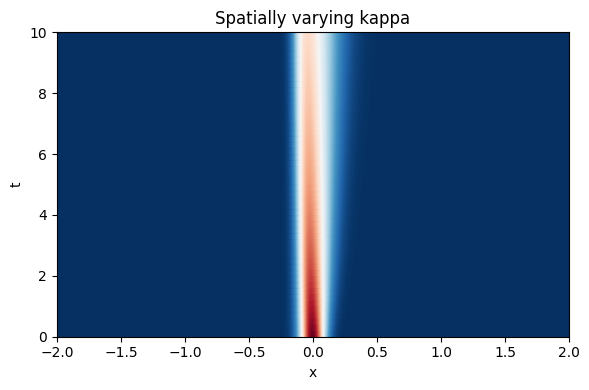

In [16]:
data = np.load('final_simulation_data.npz')
x = data['x']
t_save = data['t_save']
c_save = data['c_save']
plt.figure(figsize=(6, 4))
plt.pcolormesh(x.ravel(), np.array(t_save), np.array(c_save), cmap='RdBu_r', shading='gouraud', rasterized=True)
plt.xlim(x_start, x_end)
plt.ylim(0, solver.stop_sim_time)
plt.xlabel('x')
plt.ylabel('t')
plt.title('Spatially varying kappa')
plt.tight_layout()
plt.show()


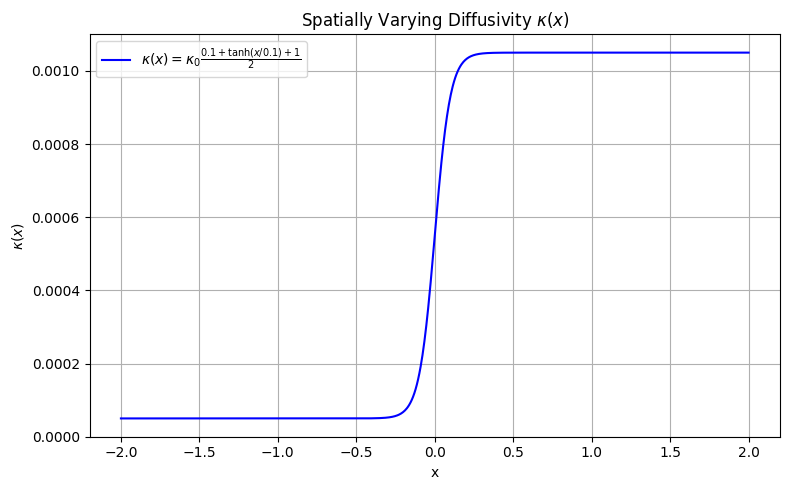

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
kappa_0 = 0.001
x = np.linspace(-2, 2, 1000)  # Define x range from -2 to 2

# Define kappa(x)
kappa = kappa_0 * (0.1 + np.tanh(x / 0.1) + 1) / 2

# Plot
plt.figure(figsize=(8, 5))
plt.plot(x, kappa, label=r'$\kappa(x) = \kappa_0 \frac{0.1 + \tanh(x/0.1) + 1}{2}$', color='blue')
plt.xlabel('x')
plt.ylabel(r'$\kappa(x)$')
plt.title('Spatially Varying Diffusivity $\kappa(x)$')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Explore the behaviour of the solution as you vary the parameters associated with $\kappa(x)$. Comment on your observations below (~1 paragraph)

The $\kappa$(x) is plotted, and we could see that its increasing acrossing x = 0, constantly positive when x>0 and vise versa. This behavior of kappa corresponded to the observed diffusion, where the diffusion is not symmetric like the constant kappa's plot. faster diffusion on the positive x side.

INSERT COMMENTS HERE

## 6. Optional further investigations

* Try writing a Dedalus script to solve the 2D diffusion equation as an initial value problem.  You can look ahead to the the example at the end of the Project 2 notebook for some guidance (but remove the advection term). I would suggest using a Fourier/Fourier basis for this.

* Consider how you might go about discretizing a 2D diffusion equation using finite differences.  What form would the matrix M have?
